# Feature Selection and Initial Modeling

##### Imports

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

import utilities.graphing_utils as utl

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)

#### Reading in Data, Making Variables

Columns chosen in *X* variable are features that share a correlation of **>= 0.1** with the target variable and correlations to each other are **<= 0.75**. These values were chosen based on heatmap correlation visuals.

In [3]:
df = pd.read_csv('./data/working_data.csv')
df.shape

(26955, 142)

In [4]:
y = df['pcpv']
X = df[['ord_cdr', 'unemploy_rate', 'arf_cdr', 'prcnt_poverty', 'pct_medicare', 
        'pct_duals', 'hpsa_part', 'nonmetro', 'op_pc', 'per_cap_medicare_cost', 
        'pdmp_req_check', 'spec_55t64_pc', 'spec_65t74_pc', 'dentists_65plus_pc', 
        'med_househld_income', 'hpsa_whole', 'prcnt_25up_college', 'pct_men', 'rural', 'per_cap_income', 
        'pct_hisp', 'np_rx']]

In [5]:
X.shape, y.shape

((26955, 22), (26955,))

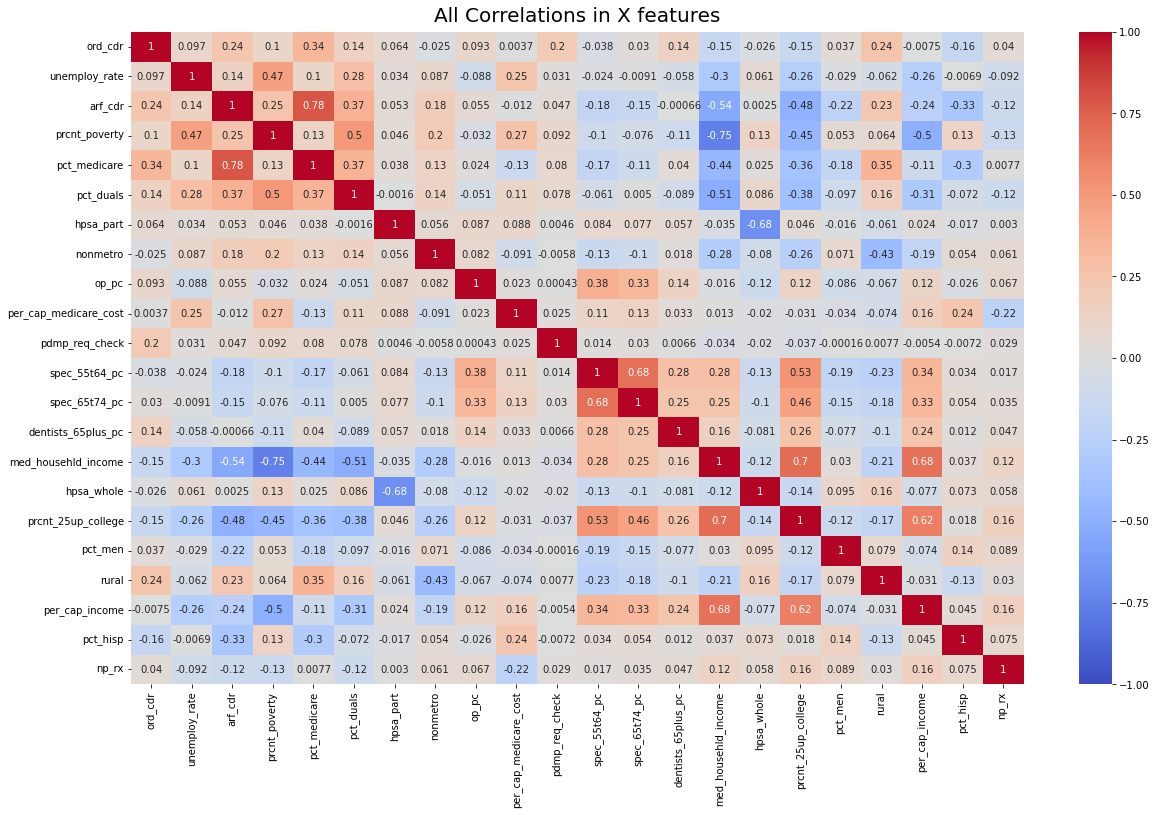

In [6]:
utl.all_corr_heatmap(data=X, title='All Correlations in X features', size_var=20)

A majority of the variables appear to have normal distributions, validating an assumption for LINEM

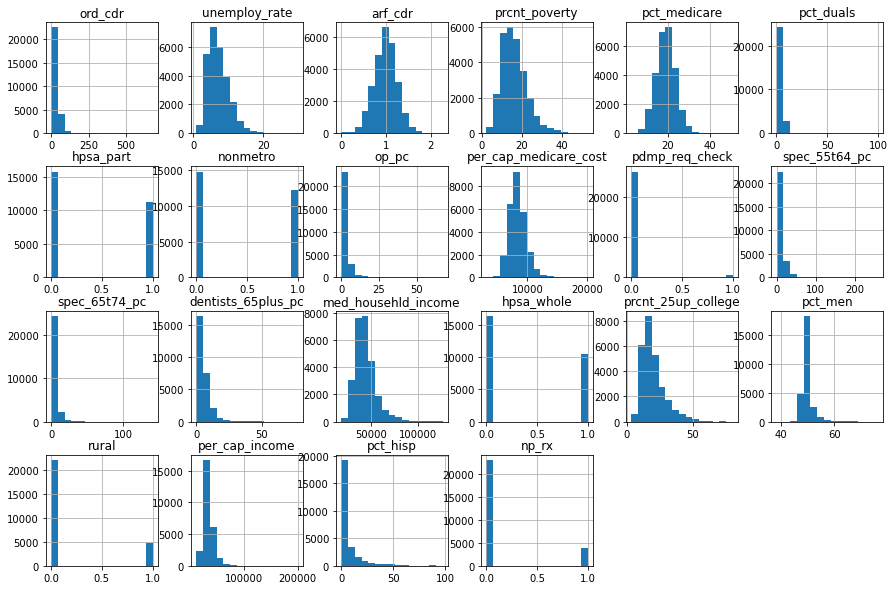

In [7]:
X.hist(bins=15, figsize=(15, 10), layout=(4,6));

#### Base Residuals and Metrics

In [8]:
# null predictions
null_pred = y.mean()
null_pred

39.350860093532646

In [9]:
# null residuals
null_residuals = y - null_pred
null_residuals[:5]

0   -39.237524
1     4.507478
2   -34.254468
3   -39.162603
4   -33.412540
Name: pcpv, dtype: float64

In [10]:
# null sum of squares
null_ss = np.sum(null_residuals**2)
null_ss

14756894.674029816

In [11]:
# mae
metrics.mean_absolute_error(y, np.full_like(y, null_pred))

17.231372847846366

### OLS Modeling

#### Fitting the Model

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [13]:
lr = LinearRegression()

In [14]:
cvs = cross_val_score(lr, X_train, y_train, cv=10)
'{} +- {}'.format(cvs.mean(), cvs.std()) 

'0.4234069383809017 +- 0.02839001740924582'

In [15]:
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
print("Training OLS score:", lr.score(X_train, y_train))
print("Testing OLS score:", lr.score(X_test, y_test))

Training OLS score: 0.4268537515076959
Testing OLS score: 0.44045567236855965


Scores between the testing and training data are consistent but low, showing there is a **high bias** but **low variance** in the model as it stands.

#### OLS Metrics

Because of the inconsistancy of variance between the low and high predictions, or **heteroscedacisity**, the target has been fit to a *Yeo-Johnson* power transformer. This, along with transforming the predictions from the training *X* variables, shows homoscedasticity in the residuals.

Further below are regression metrics derived from these transformed values.

In [17]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
yeo_y_train = power.fit_transform(y_train.array.reshape(-1,1))

preds = lr.predict(X_train)
yeo_x_preds = power.transform(preds.reshape(-1,1))

Text(0.5, 1.0, 'Checking Homoscedasticity of Residuals')

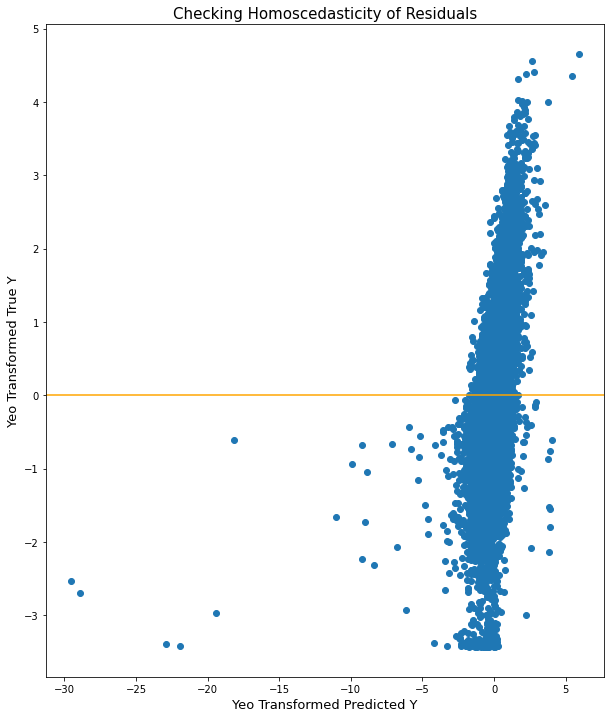

In [23]:
plt.figure(figsize=(10,12))
plt.scatter(yeo_x_preds, yeo_y_train)
plt.axhline(0, color="orange")
plt.xlabel('Yeo Transformed Predicted Y', fontsize=13)
plt.ylabel('Yeo Transformed True Y', fontsize=13)
plt.title('Checking Homoscedasticity of Residuals', fontsize=15)

In [46]:
# Mean Absolute Error
metrics.mean_absolute_error(yeo_y_train, yeo_x_preds), metrics.mean_absolute_error(y_train, preds)

(0.6060601090787868, 12.881422173207094)

In [47]:
# Sum Squared Error
rss = np.sum((yeo_y_train-yeo_x_preds)**2)
rss

16426.648849822577

In [48]:
# Mean Squared Error
metrics.mean_squared_error(yeo_y_train, yeo_x_preds)

0.7617626066510191

In [49]:
# Root Squared Mean
np.sqrt(metrics.mean_squared_error(yeo_y_train, yeo_x_preds))

0.8727901274940151

In [50]:
coef_list = list(zip(X.columns, lr.coef_))
coef_df = pd.DataFrame(coef_list, columns=['coefficients','value'])
coef_df['abs_val'] = coef_df['value'].map(lambda x: abs(x))
coef_df.sort_values(by = 'abs_val', ascending=False)[:10]

,coefficients,value,abs_val
18,rural,-16.192841,16.192841
2,arf_cdr,7.761403,7.761403
15,hpsa_whole,-7.616681,7.616681
10,pdmp_req_check,3.307507,3.307507
21,np_rx,-2.789202,2.789202
1,unemploy_rate,1.093770,1.093770
7,nonmetro,-0.841040,0.841040
17,pct_men,-0.655401,0.655401
3,prcnt_poverty,0.635396,0.635396
4,pct_medicare,0.575004,0.575004


An example on how to interpret the coefficients:
- *Holding all else constant, for a **one-unit** increase in unemployment rate, we expect to see an increase in pill volume per capita of about **1.105 units.***


#### Data Dictionary

|Feature|Type|Description|
|---|---|---|
rural|int|Indicated by the USDA Rural-Urban Continuum Code as a rural county (1,0)
arf_cdr|float|Crude annual death rate, all cause
hpsa_whole|int|Healthcase Professional Shortage Area for the whole county (1,0)
pdmp_req_check|int|Provider is required to check the states Prescription Drug Monitoring Program(s) to prescribe opioids
np_rx|int|Nurse practitioner has prescribing authority for opioids (1,0)
unemploy_rate|float|Unempoyment rate for ages 16+
nonmetro|int|Indicated by the USDA Rural-Urban Continuum Code as a nonmetro county (1,0)
pct_men|float|Percent male
prcnt_poverty|float|Percent in poverty
pct_medicare|float|Percent eliable for Medicare


#### Decision Tree Regression

In [51]:
cv = KFold(n_splits=10, 
              shuffle=True, 
              random_state=42)

# scoring function used for the method below
def score(model, name):
    s = cross_val_score(model, X, y, cv=cv)
    print("{} Score:\t{:0.2} ± {:0.2}".format(name, s.mean(), 2 * s.std()))

In [52]:
reg_tree = DecisionTreeRegressor(random_state=42)

score(reg_tree, "Decision Tree Reg.")

Decision Tree Reg. Score:	0.48 ± 0.042


#### Boosted Decision Tree Regression

In [53]:
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor()

score(ab, 'AdaBoost')
score(gb, 'Gradient Boosting Regressor')

AdaBoost Score:	0.22 ± 0.078
Gradient Boosting Regressor Score:	0.61 ± 0.027


In [54]:
gbr_params = {
    'max_depth': [3, 5, 7],
    'n_estimators': [150, 200, 250],
    'random_state': [42]
}

gbr_gridsearch = GridSearchCV(GradientBoostingRegressor(),
                             gbr_params,
                             cv=cv,
                             verbose=1,
                             n_jobs=-1)


In [55]:
gbr_gridsearch.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [150, 200, 250],
                         'random_state': [42]},
             verbose=1)

In [56]:
gbr_gridsearch.best_params_

{'max_depth': 7, 'n_estimators': 250, 'random_state': 42}

In [57]:
gbr_best_params = GradientBoostingRegressor(max_depth=4, 
                                            n_estimators=100, 
                                            random_state=42) 

gbr_best_params.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, random_state=42)

In [58]:
print("Training Gradient Boosting score:", gbr_best_params.score(X_train, y_train))
print("Testing Gradient Boosting score:", gbr_best_params.score(X_test, y_test))

Training Gradient Boosting score: 0.6865035541094552
Testing Gradient Boosting score: 0.6580080758506868


#### GA Boosted Metrics

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for.
- For this model, the performance measure was the default *'squared_error'*

In [60]:
n_scores = cross_val_score(gbr_best_params, 
                           X, y, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -10.226 (0.149)


In [61]:
gbr_best_params.feature_names_in_ ,gbr_best_params.feature_importances_

importance_list = list(zip(gbr_best_params.feature_names_in_, gbr_best_params.feature_importances_))
importance_df = pd.DataFrame(importance_list, columns=['feature','importance'])
importance_df.sort_values(by = 'importance', ascending=False)[:10]

,feature,importance
0,ord_cdr,0.316344
3,prcnt_poverty,0.116976
5,pct_duals,0.104462
18,rural,0.084607
1,unemploy_rate,0.051540
8,op_pc,0.050771
11,spec_55t64_pc,0.048000
2,arf_cdr,0.044000
4,pct_medicare,0.030517
15,hpsa_whole,0.025377


 #### Findings
 
 - Out of the top 10 variables used in this model, *ord_cdr* or the crude rate of opioid related deaths, was significantly more important in making key decisions within the tree than many other variables.
     - This is to be expected; higher concentrations of opioids per capita would naturally lead to it being over-prescribed and the eventually user populace suffering more overdoses from aided addiction by just meer convenience of the drug.

- *pct_duals* or the percent of people in the county dual-eligible for Medicare and Medicaid, has the third highest importance score in the decision tree.
    - To be eligible for Medicaid, a person must be a senior or disabled. For Medicare, a person can be of any age but be financially needy. The populous that's dual-eligible are then old or disabled people who are financially struggling, vulnerable to pill-pushing by doctors.